In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
import numpy as np

dim=250
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

FD_StencilMat=np.zeros((dim,dim))
b = np.ones(dim-1)
c = -2*np.ones(dim)
np.fill_diagonal(FD_StencilMat[1:], b)
np.fill_diagonal(FD_StencilMat[:,1:], b)
np.fill_diagonal(FD_StencilMat, c)
A=FD_StencilMat
A=np.asmatrix(A)
AType='1D Laplacian'

retrain_freq=1
e1 = 1e-3
e2 = 1e-10
nmax_iter = 50
restart   = 64

sigma=0.02
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =2000
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("Benchmark 250 dim problem. Playing with SGD.")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-05-28 22:41:12 [INFO] <ipython-input-4-a975857b6e57> 2 - Benchmark 250 dim problem. Playing with SGD.


In [5]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,Err_list,ProbCount,restart,debug,refine,blist,reslist,IterErrList10,GmresRunTime):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *




Err_list=[]
IterErrList10=[]
GmresRunTime=[]

NonML_Err_List=[]


debug=True

refine1=False
refine2=True

run_time=0.0
run_time_ML=0.0
trainTime_total=0.0
forwardTime_Total=0.0
run_time_ML_NoAdd=0.0

blist=[]
reslist=[]



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
    b=Gauss_pdf(x,loc,sigma)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,Err_list,ProbIdx,restart,debug,refine1,blist,reslist,IterErrList10,GmresRunTime)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    Err_list=OutList1[1]
    IterErr0_AVG=OutList1[2]
    trainTime1=OutList1[3]
    forwardTime1=OutList1[4]
    blist=OutList1[5]
    reslist=OutList1[6]
    IterErrList10=OutList1[7]
    GmresRunTime=OutList1[8]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,Err_list,ProbIdx,restart,debug,refine2,blist,reslist,IterErrList10,GmresRunTime)
    Out2=OutList2[0]
    Err_list=OutList2[1]
    IterErr0_AVG=OutList2[2]
    trainTime2=OutList2[3]
    forwardTime2=OutList2[4]
    blist=OutList2[5]
    reslist=OutList2[6]
    IterErrList10=OutList2[7]
    GmresRunTime=OutList2[8]

    forwardTime_Total=forwardTime1+forwardTime2+forwardTime_Total
    trainTime_total=trainTime2+trainTime1+trainTime_total
    run_time_ML=run_time1_ML+run_time2_ML+run_time_ML




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
    
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    run_time=run_time1+run_time2+run_time
    
    print(ProbIdx)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)

logger.info("Runtime of forward function is:")
logger.info(forwardTime_Total)



0
1
Final loss: 47704.66015625
Initial Training
2
0.3297424411486181 0.38058755479907386
0.6863641399977496 0.7042552509992674 0.3297424411486181 0.3529247267607258
3
0.34903499868553184 0.38058755479907386
0.6342054819979239 0.6817756059972453 0.34903499868553184 0.3441213803402102
4
0.3369839216277702 0.38058755479907386
0.6338422800035914 0.6659188979974715 0.3369839216277702 0.34575925312198413
5
0.3815047542930852 0.38058755479907386
poor prediction,using initial x0
0.7783084820039221 0.651470633999755 0.38059474929972265 0.3385871204873067
6
0.3405171217679799 0.38059474929972265
0.703143489001377 0.6831800960007968 0.3405171217679799 0.34908902769041067
7
0.2395300252954743 0.38059474929972265
0.17380279600183712 0.6873749332517036 0.2395300252954743 0.3517826978452511
8
0.3808787271690373 0.38059474929972265
poor prediction,using initial x0
0.6885576209970168 0.5846605058017303 0.3792604694861137 0.32933216333529575
9
0.3412052900912408 0.38059474929972265
0.5767504059986095 0.

InnerProd [[1.         0.82037673 0.91817898]
 [0.82037673 1.         0.95158741]
 [0.91817898 0.95158741 1.        ]]
retraining
1
Final loss: 9960.298828125
58
0.2765603601465115 0.38059474929972265
0.1140804590031621 0.44020287187944634 0.2765603601465115 0.277128155764071
59
0.09924617788302618 0.38059474929972265
0.05717037999420427 0.41936768443963957 0.09924617788302618 0.2745592067505784
60
0.37511097157296147 0.38059474929972265
0.6865130680016591 0.41125358331919415 0.37511097157296147 0.26500145590291335
61
0.27954511815349375 0.38059474929972265
0.3733729720042902 0.42346593527938237 0.27954511815349375 0.26762544698436946
62
0.2544597057052868 0.38059474929972265
0.7418465499940794 0.41211483167950064 0.2544597057052868 0.2636684702429649
63
0.15423545873621128 0.38059474929972265
0.17162855999777094 0.42941656435927145 0.15423545873621128 0.2636299764296997
64
0.2460133598262301 0.38059474929972265
0.31548617399676004 0.43024154015933164 0.2460133598262301 0.2591439992440

Final loss: 3562.402587890625
117
0.09139599279242747 0.38059474929972265
0.20388681099575479 0.340185230759962 0.09139599279242747 0.2254239378299478
118
0.14706511835880318 0.38059474929972265
0.4351417619982385 0.32310096915985925 0.14706511835880318 0.21748543832006187
119
0.37304541947862246 0.38059474929972265
0.6658900519978488 0.316307109319896 0.37304541947862246 0.21191298975623238
120
0.3904152517711194 0.38059474929972265
poor prediction,using initial x0
0.6823983039939776 0.3177756740397308 0.3760816887365505 0.2201594076178807
121
0.2631201917055305 0.38059474929972265
0.7362066060013603 0.33466910739953165 0.2631201917055305 0.22884724554244035
InnerProd [[1.         0.75929617 0.92441842]
 [0.75929617 1.         0.89057941]
 [0.92441842 0.89057941 1.        ]]
retraining
2
Final loss: 8822.6455078125
122
0.061448410350410834 0.38059474929972265
0.08617964300356107 0.33795772267971186 0.061448410350410834 0.22747944080569263
123
0.22508327927820596 0.38059474929972265
0.

176
0.27920053262468636 0.38059474929972265
0.46258891400066204 0.3843562812395976 0.27920053262468636 0.1936592666802815
177
0.03497364406128088 0.38059474929972265
0.1156369399977848 0.37436839439964387 0.03497364406128088 0.18978177438658958
178
0.13159548081005412 0.38059474929972265
0.5208138469970436 0.35162102419970326 0.13159548081005412 0.18141718270638083
179
0.19575374246320063 0.38059474929972265
0.261657513998216 0.36104270775947955 0.19575374246320063 0.1772700237944632
180
0.19362542229005322 0.38059474929972265
0.26109447999624535 0.3634950831992319 0.19362542229005322 0.18104326745367694
181
0.24039879978691608 0.38059474929972265
0.14465592199849198 0.3531812904792605 0.24039879978691608 0.1836846365518278
182
0.37767154380427903 0.38059474929972265
0.694163842999842 0.32930432863911846 0.37767154380427903 0.1818413581618236
183
0.21718214776759776 0.38059474929972265
0.46250786400196375 0.3489355424392852 0.21718214776759776 0.1935624199240349
InnerProd [[1.         

235
0.17023048722220957 0.38059474929972265
0.11463129399635363 0.3165337895200355 0.17023048722220957 0.18734881726549066
236
0.09982173212676815 0.38059474929972265
0.4027333589983755 0.3130462542397436 0.09982173212676815 0.19047770910670317
237
0.14186798520636676 0.38059474929972265
0.08564267800102243 0.32450025779980934 0.14186798520636676 0.18832210712446348
238
0.07848582252520657 0.38059474929972265
0.057405856998229865 0.3210186707999674 0.07848582252520657 0.18765887686588476
239
0.1901700170031558 0.38059474929972265
0.6569306620003772 0.32101628236006946 0.1901700170031558 0.18950163410098836
240
0.22927730997166904 0.38059474929972265
0.45989937400008785 0.3392039516402292 0.22927730997166904 0.19328641868042962
InnerProd [[1.         0.96051948 0.90975163]
 [0.96051948 1.         0.82220798]
 [0.90975163 0.82220798 1.        ]]
retraining
1
Final loss: 2636.89208984375
241
0.1926369282697795 0.38059474929972265
0.5705716869997559 0.3289505748800002 0.1926369282697795 0.

294
0.13932942169803533 0.38059474929972265
0.25895077499444596 0.30258897451945815 0.13932942169803533 0.13986178532736251
295
0.14830583047880538 0.38059474929972265
0.4581934820016613 0.3072350203592214 0.14830583047880538 0.13971768078444063
296
0.05536139570953031 0.38059474929972265
0.05703320400061784 0.3232809972393443 0.05536139570953031 0.1440379653594634
297
0.13605980264169867 0.38059474929972265
0.25964663099875906 0.3175406906794524 0.13605980264169867 0.1424483471723539
298
0.2756511196348254 0.38059474929972265
0.6025030669989064 0.30397366487944966 0.2756511196348254 0.13625269235772022
InnerProd [[1.         0.95506341 0.99349588]
 [0.95506341 1.         0.9283432 ]
 [0.99349588 0.9283432  1.        ]]
retraining
1
Final loss: 1227.609619140625
299
0.16418449728907833 0.38059474929972265
0.2323223749990575 0.3246374487594585 0.16418449728907833 0.1445216572927959
300
0.1711049889957223 0.38059474929972265
0.11574940999707906 0.32465877759968864 0.1711049889957223 0.14

356
0.15692182687442247 0.38059474929972265
0.11438973299664212 0.23985089280060493 0.15692182687442247 0.11689587491409817
357
0.12255760404108637 0.38059474929972265
0.11464886199973989 0.24101628560048993 0.12255760404108637 0.11919881027490808
358
0.1809857083321866 0.38059474929972265
0.1719181100052083 0.24327596208051547 0.1809857083321866 0.12115953624188451
359
0.19076113671591632 0.38059474929972265
0.4000202030001674 0.2382845748006366 0.19076113671591632 0.12128673636969543
InnerProd [[1.         0.84757531 0.98638168]
 [0.84757531 1.         0.80082399]
 [0.98638168 0.80082399 1.        ]]
retraining
1
Final loss: 336.0321044921875
360
0.23988891520255054 0.38059474929972265
0.5782090900029289 0.2295754482006305 0.23988891520255054 0.12329416253324617
361
0.08004098616635329 0.38059474929972265
0.23040292599762324 0.2360977737608482 0.08004098616635329 0.13003971364621683
362
0.06644367252658676 0.38059474929972265
0.08621261399821378 0.23351105476060183 0.0664436725265867

415
0.11906700457668161 0.38059474929972265
0.20034212400059914 0.25328957264020574 0.11906700457668161 0.12630184427205066
416
0.12443731813507625 0.38059474929972265
0.11363752299803309 0.25328968212008474 0.12443731813507625 0.12340692307306422
417
0.1597167797703514 0.38059474929972265
0.14340279300085967 0.25440164900006496 0.1597167797703514 0.12587036409785218
418
0.05035972719973101 0.38059474929972265
0.37187792099575745 0.25673137984005734 0.05035972719973101 0.12829476224309505
419
0.16301220531479088 0.38059474929972265
0.11384201900364133 0.2475129830799415 0.16301220531479088 0.12448876713387452
420
0.06982450813064667 0.38059474929972265
0.05677135800215183 0.23720468028011965 0.06982450813064667 0.12152473639014894
421
0.12065048697123495 0.38059474929972265
0.21087774400075432 0.2348961903603049 0.12065048697123495 0.12124593015388578
422
0.1449510887251006 0.38059474929972265
0.11445579300198006 0.22954514484037644 0.1449510887251006 0.12099192253229071
423
0.14788481

474
0.18679310237453253 0.38059474929972265
0.2036886739952024 0.24363585344020977 0.18679310237453253 0.11655505793312246
475
0.16768600912133919 0.38059474929972265
0.08669287399970926 0.2494765606400324 0.16768600912133919 0.12209234439284782
476
0.045845139294588874 0.38059474929972265
0.029228507999505382 0.22972299955989 0.045845139294588874 0.11899921390793729
477
0.12734435742330227 0.38059474929972265
0.05774972999643069 0.21924923191982088 0.12734435742330227 0.11892939333524952
478
0.0542588026338334 0.38059474929972265
0.23220481099997414 0.21810883451951668 0.0542588026338334 0.12291832701372328
479
0.15553140667309293 0.38059474929972265
0.4945536449959036 0.20073365155956707 0.15553140667309293 0.11778685515669876
480
0.06903298996482912 0.38059474929972265
0.1748873510005069 0.21820272787939757 0.06903298996482912 0.12156223985167508
481
0.02705459098215309 0.38059474929972265
0.05796775699855061 0.20331645011960064 0.02705459098215309 0.11939863447869702
482
0.33126804

0.31364326999755576 0.30037410807970444 0.1363551528546789 0.11687579662339001
535
0.2276060988832635 0.38059474929972265
0.14305500499904156 0.2940985718395677 0.2276060988832635 0.1188759314774355
536
0.320882021755986 0.38059474929972265
0.5976805109967245 0.2939304544395418 0.320882021755986 0.12412898491905819
537
0.15674047563636742 0.38059474929972265
0.08485556000232464 0.2954924149994622 0.15674047563636742 0.1284535093608909
538
0.11548209479503015 0.38059474929972265
0.5442270950006787 0.29187189847958506 0.11548209479503015 0.1295615302995729
539
0.22637433319073152 0.38059474929972265
0.14259507099632174 0.3018328400395694 0.22637433319073152 0.13170626031917737
540
0.0977242159474048 0.38059474929972265
0.17271774399705464 0.30285683739959496 0.0977242159474048 0.13895464619503195
541
0.12207276889552508 0.38059474929972265
0.3998799199980567 0.29804098107939353 0.12207276889552508 0.14047715305604497
542
0.12190639853152244 0.38059474929972265
0.11465907099773176 0.30818

596
0.17671599697636195 0.38059474929972265
0.056769032999000046 0.27260832236032 0.17671599697636195 0.0985013897480983
597
0.04201974246316993 0.38059474929972265
0.2292080109982635 0.27145651504048146 0.04201974246316993 0.10434524568245288
598
0.059189445755146786 0.38059474929972265
0.1423953289995552 0.2726075238804333 0.059189445755146786 0.10165375247625935
599
0.12925807553723564 0.38059474929972265
0.11405502199340845 0.2622670598802506 0.12925807553723564 0.10053068665655263
600
0.0879740109962548 0.38059474929972265
0.4878235560026951 0.2622889207600383 0.0879740109962548 0.10182945125659341
601
0.057186322924338895 0.38059474929972265
0.1432232219958678 0.2795252528801211 0.057186322924338895 0.10394950701401102
602
0.07091818710026818 0.38059474929972265
0.05698198300524382 0.28066431563987865 0.07091818710026818 0.1039557329397038
603
0.26137958911517195 0.38059474929972265
0.6288629400005448 0.27606188648031094 0.26137958911517195 0.10062814099502028
604
0.0799440815535

Final loss: 730.9156494140625
657
0.08858315582629157 0.38059474929972265
0.369605744999717 0.31094232592062326 0.08858315582629157 0.13483540731948465
658
0.1593017559525343 0.38059474929972265
0.08527131599839777 0.300382752440637 0.1593017559525343 0.12894153089227178
659
0.12717910209993596 0.38059474929972265
0.22869467500277096 0.3015004942403175 0.12717910209993596 0.1333299348957976
660
0.11593381739971256 0.38059474929972265
0.11440553500142414 0.30026833360054295 0.11593381739971256 0.13296949633749025
661
0.10331125116748086 0.38059474929972265
0.05675217200041516 0.3025422954405076 0.10331125116748086 0.13653274551611136
662
0.08929501258347775 0.38059474929972265
0.2008445569954347 0.2851161509603844 0.08929501258347775 0.13404437119907273
663
0.11220341594422648 0.38059474929972265
0.05710048699984327 0.2840157428002567 0.11220341594422648 0.13517125743574832
664
0.03763506723542007 0.38059474929972265
0.20138529199903132 0.26797722380026245 0.03763506723542007 0.13275227

0.23078175199771067 0.22809670579998056 0.10941883800069323 0.09854092234445248
719
0.11483741671809469 0.38059474929972265
0.20108945399988443 0.22355953871970996 0.11483741671809469 0.0985036269400562
720
0.12691247372495154 0.38059474929972265
0.45843801199953305 0.2223560872397502 0.12691247372495154 0.10169960572009563
InnerProd [[1.         0.97823218 0.84853665]
 [0.97823218 1.         0.78524579]
 [0.84853665 0.78524579 1.        ]]
retraining
1
Final loss: 607.260986328125
721
0.0844709344484975 0.38059474929972265
0.08688095999968937 0.23954013107984792 0.0844709344484975 0.10583469956912599
722
0.07897917382780863 0.38059474929972265
0.08795346899569267 0.22801374535978539 0.07897917382780863 0.10376569427384054
723
0.11388067520323021 0.38059474929972265
0.11631410099653294 0.21656680767977377 0.11388067520323021 0.10148756106681057
724
0.10120312715300814 0.38059474929972265
0.5218971939975745 0.20509088183986024 0.10120312715300814 0.1007483949244323
725
0.119908457118409

Final loss: 400.7808837890625
779
0.12558872468962465 0.38059474929972265
0.34546286900149425 0.19888138384150808 0.12558872468962465 0.09799551234461822
780
0.2099067664152163 0.38059474929972265
0.5150649569986854 0.1863264610816259 0.2099067664152163 0.09476661758275089
781
0.05599137203876808 0.38059474929972265
0.1431190820003394 0.2046548717614496 0.05599137203876808 0.10050694825839104
782
0.03640046223268287 0.38059474929972265
0.057159372001478914 0.2046452260413207 0.03640046223268287 0.10037896568781932
783
0.0196655190748774 0.38059474929972265
0.028916848001244944 0.20239718312135666 0.0196655190748774 0.09394861651472337
784
0.09890422037260176 0.38059474929972265
0.20613481000327738 0.19416149600147037 0.09890422037260176 0.09300339401299337
InnerProd [[1.         0.89828032 0.93718701]
 [0.89828032 1.         0.78677807]
 [0.93718701 0.78677807 1.        ]]
retraining
1
Final loss: 749.3870239257812
785
0.02041523093310923 0.38059474929972265
0.057036367994442116 0.1989

840
0.06095316090575727 0.38059474929972265
0.11482615199929569 0.20921111083967844 0.06095316090575727 0.08819501796342215
841
0.10524982926005667 0.38059474929972265
0.14387065700429957 0.19416720123961567 0.10524982926005667 0.08508279465978325
842
0.09214652927662627 0.38059474929972265
0.1725166799951694 0.1976179437196697 0.09214652927662627 0.08803896401780349
843
0.06049925808052073 0.38059474929972265
0.14334178299759515 0.20219444127957104 0.06049925808052073 0.08869509574169725
844
0.13877483061197435 0.38059474929972265
0.11528294600429945 0.18701122887956445 0.13877483061197435 0.08323954996656678
845
0.026627337520927368 0.38059474929972265
0.028797849001421127 0.18929948491975665 0.026627337520927368 0.08606130678220048
846
0.14377017283482088 0.38059474929972265
0.14332378799736034 0.1858656128399889 0.14377017283482088 0.08236641755949106
847
0.11015512889176218 0.38059474929972265
0.376454992001527 0.18813416719989617 0.11015512889176218 0.0851711855152084
848
0.04509

900
0.18070219010064115 0.38059474929972265
0.5262262659962289 0.1886452920801821 0.18070219010064115 0.06955604454891166
901
0.1846189398092268 0.38059474929972265
0.1567258130016853 0.20740515612007585 0.1846189398092268 0.07486012897770937
902
0.039566925227162465 0.38059474929972265
0.0573807089967886 0.2102575308800442 0.039566925227162465 0.081177292008284
903
0.16895590307186545 0.38059474929972265
0.11575114900188055 0.21027078167971922 0.16895590307186545 0.08001187945595702
904
0.14819733693978063 0.38059474929972265
0.46125883200147655 0.21375571819982725 0.14819733693978063 0.08503947120927982
905
0.11404799857266452 0.38059474929972265
0.11389687599876197 0.21352611012000125 0.11404799857266452 0.0864355564799885
906
0.14062719344374425 0.38059474929972265
0.1440240049996646 0.20180326008005067 0.14062719344374425 0.087561571575646
907
0.07109951789776121 0.38059474929972265
0.4058648960053688 0.2005827083598706 0.07109951789776121 0.08934765123336548
908
0.077359353410823

962
0.07258967038826251 0.38059474929972265
0.058898541996313725 0.1655845952403615 0.07258967038826251 0.09476836575186418
963
0.08088502070513583 0.38059474929972265
0.32577372399828164 0.1667874220001977 0.08088502070513583 0.09609459583308849
964
0.0756630735669487 0.38059474929972265
0.14811740000004647 0.1763945591202355 0.0756630735669487 0.09686984643251335
965
0.03466990839268555 0.38059474929972265
0.05889278199902037 0.17774852448026648 0.03466990839268555 0.09598261675487568
966
0.0483876801375765 0.38059474929972265
0.05795414399472065 0.17325730372045656 0.0483876801375765 0.09339433624566038
967
0.08926579662077351 0.38059474929972265
0.058374498003104236 0.16632920180010843 0.08926579662077351 0.09411947437664274
968
0.03644365588450403 0.38059474929972265
0.05825705100141931 0.15820895232027396 0.03644365588450403 0.09602495959911715
969
0.07295691387411395 0.38059474929972265
0.2343292779987678 0.15825593120040138 0.07295691387411395 0.09562722480530997
970
0.20649344

1023
0.029152586056767626 0.38059474929972265
0.0867711240061908 0.21099462588026655 0.029152586056767626 0.07911895309441534
1024
0.10273999583132198 0.38059474929972265
0.4657052289985586 0.1994385072804289 0.10273999583132198 0.07797093188825951
1025
0.12162261343841999 0.38059474929972265
0.4976082689972827 0.21577787940041163 0.12162261343841999 0.08069520222955762
InnerProd [[1.         0.86042266 0.82403999]
 [0.86042266 1.         0.99215001]
 [0.82403999 0.99215001 1.        ]]
retraining
1
Final loss: 110.03905487060547
1026
0.03360758000936465 0.38059474929972265
0.029530159001296852 0.21708272312011104 0.03360758000936465 0.07892568088023882
1027
0.08185863846511585 0.38059474929972265
0.23527934000594541 0.21008012208039872 0.08185863846511585 0.0757703154352079
1028
0.03697343400844977 0.38059474929972265
0.2639722329986398 0.21832176696072567 0.03697343400844977 0.07750609690800914
1029
0.07765154713968554 0.38059474929972265
0.23462708499573637 0.2265653985206154 0.0776

1082
0.0580700954664277 0.38059474929972265
0.028746435993525665 0.2083469720801804 0.0580700954664277 0.09883085540561252
1083
0.038048515529342075 0.38059474929972265
0.028974628003197722 0.19803524995979388 0.038048515529342075 0.09718274609954407
1084
0.13137566798734024 0.38059474929972265
0.5750499660061905 0.18170689031976509 0.13137566798734024 0.09466407726020189
1085
0.10151982318710415 0.38059474929972265
0.4315088729999843 0.20354444928001614 0.10151982318710415 0.09792498394472676
InnerProd [[1.         0.90507347 0.96436011]
 [0.90507347 1.         0.97451105]
 [0.96436011 0.97451105 1.        ]]
retraining
1
Final loss: 198.82806396484375
1086
0.04981552952874871 0.38059474929972265
0.08583264199842233 0.21615411771985238 0.04981552952874871 0.0994689996010542
1087
0.08525988639677683 0.38059474929972265
0.316661019998719 0.21142823879985373 0.08525988639677683 0.09360985123791479
1088
0.08375511796773223 0.38059474929972265
0.5439541960004135 0.22062616199982585 0.08375

1143
0.10157052868563252 0.38059474929972265
0.2055305529938778 0.1117102821203298 0.10157052868563252 0.07328721354656223
1144
0.03318259433851548 0.38059474929972265
0.057843704998958856 0.11467897288006497 0.03318259433851548 0.07380005253642367
1145
0.16602306620542615 0.38059474929972265
0.5898059669998474 0.11231402851990424 0.16602306620542615 0.07214723652738728
InnerProd [[1.         0.98086035 0.90266012]
 [0.98086035 1.         0.84644298]
 [0.90266012 0.84644298 1.        ]]
retraining
1
Final loss: 203.14796447753906
1146
0.05762905286813515 0.38059474929972265
0.05726184300146997 0.13122394331992837 0.05762905286813515 0.07605047386386492
1147
0.09155875583999705 0.38059474929972265
0.11507005500607193 0.132345710840018 0.09155875583999705 0.07593402765691579
1148
0.029931671987860092 0.38059474929972265
0.05726452399539994 0.12485251764010172 0.029931671987860092 0.07607233249019406
1149
0.07297557756820977 0.38059474929972265
0.057476284993754234 0.12482440388004762 0.0

1204
0.07095145688993325 0.38059474929972265
0.05704223999782698 0.12349131743976613 0.07095145688993325 0.050215913619178834
1205
0.07369877555791239 0.38059474929972265
0.11353159099962795 0.12346028783969815 0.07369877555791239 0.050832383259346116
1206
0.061541843490162694 0.38059474929972265
0.08553975499671651 0.1245609505198081 0.061541843490162694 0.05116577114997606
1207
0.047047224022001406 0.38059474929972265
0.02868166500411462 0.12682844175957142 0.047047224022001406 0.0522457723156501
1208
0.08778679900613252 0.38059474929972265
0.1432885569956852 0.12567785959981848 0.08778679900613252 0.0519308873289021
InnerProd [[1.         0.93989777 0.78865742]
 [0.93989777 1.         0.90203569]
 [0.78865742 0.90203569 1.        ]]
retraining
2
Final loss: 156.83905029296875
1209
0.022344635414603214 0.38059474929972265
0.02879300300264731 0.13025097783945966 0.022344635414603214 0.0543855116509393
1210
0.03060326108411682 0.38059474929972265
0.02866058400104521 0.13024865899962607

1264
0.082120326698634 0.38059474929972265
0.20548321700334782 0.1373015914001735 0.082120326698634 0.07545357692655996
InnerProd [[1.         0.82591447 0.8888995 ]
 [0.82591447 1.         0.97826562]
 [0.8888995  0.97826562 1.        ]]
retraining
1
Final loss: 436.783203125
1265
0.03545275491638685 0.38059474929972265
0.2874583859957056 0.14436630568030523 0.03545275491638685 0.07704106913575788
1266
0.13446701244406936 0.38059474929972265
0.08580767999956151 0.15359019436000382 0.13446701244406936 0.07689355623274824
1267
0.07234355517049726 0.38059474929972265
0.11481255399849033 0.1547490499599371 0.07234355517049726 0.07677265999738635
1268
0.05740604779862981 0.38059474929972265
0.14453863500239095 0.15591595379984938 0.05740604779862981 0.07601615044686637
1269
0.06321045110269538 0.38059474929972265
0.08620766699459637 0.15942447075998645 0.06321045110269538 0.07495548135071432
1270
0.06582378746160866 0.38059474929972265
0.4036755049964995 0.1605975955197937 0.06582378746160

1326
0.011094055021318525 0.38059474929972265
0.0288035330013372 0.11668310952110915 0.011094055021318525 0.06838857795437964
1327
0.01720716525132121 0.38059474929972265
0.11441096899943659 0.11667654548131395 0.01720716525132121 0.06755780619555508
1328
0.026192298644218716 0.38059474929972265
0.05734484099957626 0.12010218248120509 0.026192298644218716 0.06586995170845136
1329
0.03192617264669808 0.38059474929972265
0.057116687996312976 0.12010209208092419 0.03192617264669808 0.06355260792284873
1330
0.08808111171547545 0.38059474929972265
0.17160552800487494 0.12121877996076363 0.08808111171547545 0.06358283576265956
InnerProd [[1.         0.99189316 0.99954929]
 [0.99189316 1.         0.99496623]
 [0.99954929 0.99496623 1.        ]]
retraining
1
Final loss: 2297.4248046875
1331
0.08309218495886113 0.38059474929972265
0.11478645800525555 0.10478847368096467 0.08309218495886113 0.061125507553052856
1332
0.10765017002335212 0.38059474929972265
0.4888859990023775 0.10708693668129854 0

1384
0.0756151033034065 0.38059474929972265
0.08533321900176816 0.11846504903980531 0.0756151033034065 0.059561079415413734
1385
0.08135077968309187 0.38059474929972265
0.05698705699614948 0.11956783983972855 0.08135077968309187 0.060512879031241494
1386
0.071247289148199 0.38059474929972265
0.08621567099908134 0.10788211763952858 0.071247289148199 0.06139539559436955
1387
0.0636634257719848 0.38059474929972265
0.08591177199559752 0.11015117083938093 0.0636634257719848 0.06257564487251532
1388
0.06111318681378407 0.38059474929972265
0.23028439799963962 0.11124351975915488 0.06111318681378407 0.0629037946749811
1389
0.07618564397054448 0.38059474929972265
0.20123939699988114 0.11811370147916023 0.07618564397054448 0.06308234542243409
1390
0.031914132573278804 0.38059474929972265
0.056996624000021257 0.12144527851924067 0.031914132573278804 0.06498089040471267
1391
0.06413180418065735 0.38059474929972265
0.057237000997702125 0.12252902019943576 0.06413180418065735 0.0655822069492715
1392

1445
0.08822799787727001 0.38059474929972265
0.11496601600083522 0.12293095744098537 0.08822799787727001 0.057904996113887525
1446
0.0591177567616413 0.38059474929972265
0.25959049399534706 0.12521972508111504 0.0591177567616413 0.06037426338725077
1447
0.0194685663326776 0.38059474929972265
0.028758133994415402 0.12382907248073025 0.0194685663326776 0.057028458414674195
1448
0.08115196473711915 0.38059474929972265
0.05705622799723642 0.1050427711204975 0.08115196473711915 0.055305487674212915
1449
0.04633796469029793 0.38059474929972265
0.25872270700347144 0.10616474048030795 0.04633796469029793 0.057245515508456996
1450
0.0613099850423719 0.38059474929972265
0.057127305000904016 0.11307741056021768 0.0613099850423719 0.057493122157696266
1451
0.03580756701156209 0.38059474929972265
0.08522859300137497 0.11305636544013396 0.03580756701156209 0.05712041396063346
1452
0.048266212918281676 0.38059474929972265
0.05697737899754429 0.1130051693203859 0.048266212918281676 0.05608268332888001

1507
0.043790581013431 0.38059474929972265
0.02916584099875763 0.08641586711950368 0.043790581013431 0.051227682844527334
1508
0.07152806926223311 0.38059474929972265
0.057745268000871874 0.08182077491946985 0.07152806926223311 0.048199449500778375
1509
0.04358527672341911 0.38059474929972265
0.2658338469991577 0.07722305503935786 0.04358527672341911 0.04899876737685591
1510
0.09632097601593916 0.38059474929972265
0.08672995399683714 0.08556818855926394 0.09632097601593916 0.04970131861168005
InnerProd [[1.         0.99930962 0.78721701]
 [0.99930962 1.         0.77723858]
 [0.78721701 0.77723858 1.        ]]
retraining
3
Final loss: 110.79537200927734
1511
0.04613541439309025 0.38059474929972265
0.3219635589994141 0.07174458527908428 0.04613541439309025 0.04733491260550331
1512
0.022721627751568604 0.38059474929972265
0.029143366999051068 0.08346805939916521 0.022721627751568604 0.0477846314009531
1513
0.08871062468136565 0.38059474929972265
0.2946890719977091 0.08347759247932117 0.08

1568
0.015486537274765498 0.38059474929972265
0.02953337299550185 0.0915049858004204 0.015486537274765498 0.04851477061823812
1569
0.0298201144002489 0.38059474929972265
0.029714837997744326 0.09153735744010191 0.0298201144002489 0.04841420042290458
1570
0.03439739027333167 0.38059474929972265
0.08919066600356018 0.0915750515999389 0.03439739027333167 0.048921695399393214
1571
0.05500086205209197 0.38059474929972265
0.17747565399622545 0.09398930652008858 0.05500086205209197 0.04852455252888357
1572
0.06790552501351194 0.38059474929972265
0.32761958400078584 0.09993467855994823 0.06790552501351194 0.04892367111154981
1573
0.03244522342041851 0.38059474929972265
0.05864280999958282 0.1107587309597875 0.03244522342041851 0.050698055359371684
1574
0.06315681134945011 0.38059474929972265
0.05849450600362616 0.10156122887972742 0.06315681134945011 0.04966071581913135
1575
0.06004144965310648 0.38059474929972265
0.02962039599515265 0.09343354063981678 0.06004144965310648 0.05047325093374137


1629
0.012008090624488463 0.38059474929972265
0.02902279900445137 0.10077860479941592 0.012008090624488463 0.05603892103467932
1630
0.033684111667765436 0.38059474929972265
0.31893429400224704 0.09847101591964019 0.033684111667765436 0.055250288488784154
1631
0.029656743326316563 0.38059474929972265
0.028912541005411185 0.11006085531989811 0.029656743326316563 0.05472127010695151
1632
0.06117202568508932 0.38059474929972265
0.05721135199564742 0.1089051028402173 0.06117202568508932 0.0551709441614091
1633
0.011301497399015512 0.38059474929972265
0.028922919002070557 0.11001977484003873 0.011301497399015512 0.055553796289222364
1634
0.03463707208078404 0.38059474929972265
0.057642519001092296 0.11000542412017239 0.03463707208078404 0.054517185505134326
1635
0.023284557594606004 0.38059474929972265
0.028949267994903494 0.10770646220014896 0.023284557594606004 0.05173290001285187
1636
0.025487776464161616 0.38059474929972265
0.057395421994442586 0.10767618715995923 0.025487776464161616 0.

1691
0.08602427966882037 0.38059474929972265
0.2056876229980844 0.06670555939956102 0.08602427966882037 0.050524143440890165
InnerProd [[1.         0.68590486 0.80925079]
 [0.68590486 1.         0.92752402]
 [0.80925079 0.92752402 1.        ]]
retraining
2
Final loss: 89.10633850097656
1692
0.030112827423455182 0.38059474929972265
0.0572088539993274 0.07143798835953931 0.030112827423455182 0.052004476380555345
1693
0.0516919654958623 0.38059474929972265
0.057180245996278245 0.06908023007970769 0.0516919654958623 0.049653770267869664
1694
0.09546832577948958 0.38059474929972265
0.37548399200022686 0.06673113123950315 0.09546832577948958 0.04853048281324512
1695
0.03147559703664764 0.38059474929972265
0.028733140003168955 0.07944185747968731 0.03147559703664764 0.05007290425604499
1696
0.050165912766629225 0.38059474929972265
0.062269602000014856 0.07708099463983671 0.050165912766629225 0.04917965470923919
1697
0.04632337539402059 0.38059474929972265
0.14234360499540344 0.078406878359965

1752
0.027427681164987137 0.38059474929972265
0.0582131240007584 0.10402259428054095 0.027427681164987137 0.05263078522687314
1753
0.013080870560730718 0.38059474929972265
0.02908928100077901 0.10519468124053674 0.013080870560730718 0.053285757270193225
1754
0.04931089794880398 0.38059474929972265
0.028773471996828448 0.10406490112043684 0.04931089794880398 0.05114075754738581
1755
0.053925081960082076 0.38059474929972265
0.11429717999999411 0.10293653492029989 0.053925081960082076 0.05076771010237458
InnerProd [[1.         0.9948741  0.94026399]
 [0.9948741  1.         0.91484175]
 [0.94026399 0.91484175 1.        ]]
retraining
1
Final loss: 328.4276123046875
1756
0.01694930002393617 0.38059474929972265
0.0293131779981195 0.10635128692025318 0.01694930002393617 0.05164072941634732
1757
0.006212530016789527 0.38059474929972265
0.029202787001850083 0.10636396672023693 0.006212530016789527 0.0511541608086222
1758
0.029737496750624624 0.38059474929972265
0.05785284400189994 0.106378627840

1811
0.0515436473765623 0.38059474929972265
0.029054998005449306 0.048750089399982245 0.0515436473765623 0.029075573428367224
1812
0.018402941810857377 0.38059474929972265
0.029000755996094085 0.04874499640020076 0.018402941810857377 0.030498687749906318
1813
0.03853769416014947 0.38059474929972265
0.057372338997083716 0.04760131343995454 0.03853769416014947 0.030310362073877446
InnerProd [[1.         0.99952993 0.99881305]
 [0.99952993 1.         0.99982595]
 [0.99881305 0.99982595 1.        ]]
retraining
1
Final loss: 411.96380615234375
1814
0.027977933323215683 0.38059474929972265
0.0581238820013823 0.047576393639610616 0.027977933323215683 0.030635701258155373
1815
0.04569738609188576 0.38059474929972265
0.02894140900025377 0.047590000719646926 0.04569738609188576 0.030214980380827764
1816
0.03795528386362888 0.38059474929972265
0.029060469001706224 0.04643991471966728 0.03795528386362888 0.029383283831899018
1817
0.024867248012189782 0.38059474929972265
0.029150391004804987 0.0453

1871
0.06322033764453217 0.38059474929972265
0.05882779599778587 0.06291035487927729 0.06322033764453217 0.04185978208789222
1872
0.04763369192276948 0.38059474929972265
0.02990032500383677 0.06298745587933809 0.04763369192276948 0.04360493964984357
1873
0.08055102005439635 0.38059474929972265
0.23731880899867974 0.06303743403957923 0.08055102005439635 0.044175784451020605
InnerProd [[1.         0.87577838 0.91235549]
 [0.87577838 1.         0.73386994]
 [0.91235549 0.73386994 1.        ]]
retraining
1
Final loss: 117.5008773803711
1874
0.053722558593275745 0.38059474929972265
0.057403148006414995 0.0713824439997552 0.053722558593275745 0.04643799481231567
1875
0.007355228944570147 0.38059474929972265
0.028700408001895994 0.07252402904006885 0.007355228944570147 0.047787340282013854
1876
0.03908215748104522 0.38059474929972265
0.05699910700059263 0.07252208156016422 0.03908215748104522 0.04711881568694935
1877
0.039746806197466115 0.38059474929972265
0.05684698799450416 0.0736549596002

1931
0.019056447781755238 0.38059474929972265
0.028691088999039494 0.03828345816029469 0.019056447781755238 0.036849140048740736
1932
0.0314365800639562 0.38059474929972265
0.11377660399739398 0.0370923928002594 0.0314365800639562 0.03606358656133318
1933
0.030157035395014603 0.38059474929972265
0.02871569400303997 0.04048037100001238 0.030157035395014603 0.03621269253095107
1934
0.02504997050527972 0.38059474929972265
0.028679442999418825 0.040473966320278124 0.02504997050527972 0.0357547178412379
1935
0.07038532629759497 0.38059474929972265
0.05699173999892082 0.04046760828030529 0.07038532629759497 0.03591664656266561
1936
0.03457325557015237 0.38059474929972265
0.028711812999972608 0.04044900960027007 0.03457325557015237 0.03419965661323631
1937
0.019572823756420037 0.38059474929972265
0.028718759000184946 0.040433214560325725 0.019572823756420037 0.035202166838056284
1938
0.05408922318344824 0.38059474929972265
0.05682597000122769 0.04041538108023815 0.05408922318344824 0.03435036

1991
0.11143755926166583 0.38059474929972265
0.29592215699813096 0.0574585993195069 0.11143755926166583 0.04097484121891745
InnerProd [[1.         0.72301349 0.83888892]
 [0.72301349 1.         0.93693438]
 [0.83888892 0.93693438 1.        ]]
retraining
2
Final loss: 32.74150085449219
1992
0.042432183548564525 0.38059474929972265
0.05726441200386034 0.0658493098395411 0.042432183548564525 0.04087547063602982
1993
0.02793534137152728 0.38059474929972265
0.02890241699788021 0.06698886431957363 0.02793534137152728 0.04103330890980314
1994
0.04237107106160307 0.38059474929972265
0.057170808999217115 0.05774630895961309 0.04237107106160307 0.03777390106862713
1995
0.010563311275117096 0.38059474929972265
0.028884072999062482 0.056545113119645975 0.010563311275117096 0.03831478188730564
1996
0.03315951423631518 0.38059474929972265
0.057378899000468664 0.05650596051971661 0.03315951423631518 0.035940774560779244
1997
0.03328294135602203 0.38059474929972265
0.02878866899845889 0.05760991179995

2020-05-29 01:17:01 [INFO] <ipython-input-6-47d32c120560> 76 - Runtime of Non-decorated version is:
2020-05-29 01:17:01 [INFO] <ipython-input-6-47d32c120560> 77 - 4987.5767319660445
2020-05-29 01:17:01 [INFO] <ipython-input-6-47d32c120560> 79 - Runtime of MLGMRES decorator is:
2020-05-29 01:17:01 [INFO] <ipython-input-6-47d32c120560> 80 - 4301.178412831032
2020-05-29 01:17:01 [INFO] <ipython-input-6-47d32c120560> 83 - Runtime of training (backprop) is:
2020-05-29 01:17:01 [INFO] <ipython-input-6-47d32c120560> 84 - 188.3814259609644
2020-05-29 01:17:01 [INFO] <ipython-input-6-47d32c120560> 86 - Runtime of forward function is:
2020-05-29 01:17:01 [INFO] <ipython-input-6-47d32c120560> 87 - 1.8247590360260801


1999


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

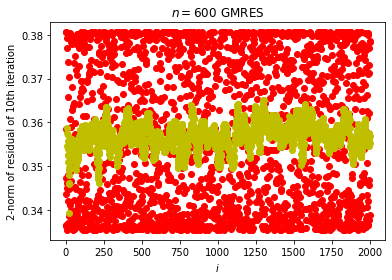

In [9]:
AVG=np.zeros((2000,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,2000)
for j in range(0,2000):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'or',count[10:-1],AVG[10:-1],'oy')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$n=600$ GMRES')
pp.savefig('GMRES.png')

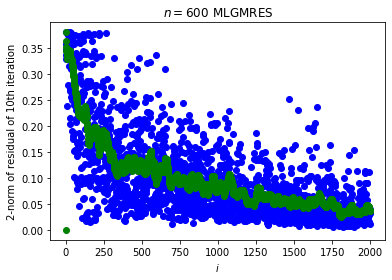

In [10]:
Err_Array_ML=np.asarray(IterErrList10)
AVGML=np.zeros((2000,1))

for j in range(0,2000):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)
pp.plot(count,np.asarray(Err_Array_ML),'ob',count,AVGML,'og')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$n=600$ MLGMRES')
pp.savefig('MLGMRES.png')

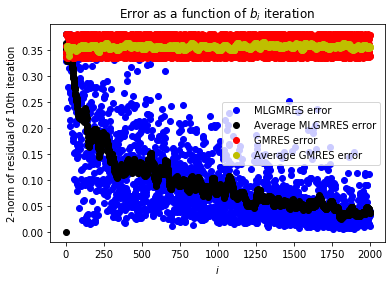

In [11]:
pp.plot(count,Err_Array_ML,'ob',label='MLGMRES error')
pp.plot(count,AVGML,'ok',label='Average MLGMRES error')
pp.plot(count,Err_Array,'or',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'oy',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('Error as a function of $b_i$ iteration ')
pp.legend(loc='best')
pp.savefig('Compare.png')